# Financial Fraud Detection

Technology is growing exponentially everyday, and this advancement is affecting each and every major business sector. It is very evident that this is the digital age and business interactions have completely changed.

The increasing demand for digital banking experience by the customers has completely changed the way in which the banking sector operates. Mobile Banking has its hand in almost every aspect of the banking industry.

Most of our transactions nowadays, be it account transfer, making deposits, monitoring our spendings and earnings are done through Mobile Banking. All your transactions are just a click away, which seemed very unlikely a few years ago. 

It seems everything’s great, is it ?

One of the major concerns that consumers have with digital banking is security. The fear of data breach or any kind of fraud increases the need for services that keep user’s data secure and be fraud proof.The financial services industry and the industries that involve financial transactions are suffering from fraud-related losses and damages.

**So, the challenge for industry players is to implement real-time claim assessment and improve the accuracy of fraud detection.**


### Problem Statement:

Can we predict whether there has been a fraudulent transaction using Machine Learning techniques?

Steps:

1.	Exploratory Data Analysis
2.	Data Cleaning
3.	Feature Engineering
4.	Data Visualization
5.	Machine Learning Approach to detect fraud
6.	Model Improvement





#### Data :

Transactional data containing more than 6 million rows has been provided. All the transactions have been done through mobile banking. It contains 11 columns, and the description of each of the column has been provided below:

This is a sample of 1 row with headers explanation:

*1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0*

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
* amount - amount of the transaction in local currency.
* nameOrig - customer who started the transaction
* oldbalanceOrg - initial balance before the transaction
* newbalanceOrig - new balance after the transaction
* nameDest - customer who is the recipient of the transaction
* oldbalanceDest - initial balance recipient before the transaction. Note that there is no information for customers that start with M (Merchants).
* newbalanceDest - new balance recipient after the transaction. Note that there is no information for customers that start with M (Merchants).
* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


**import libraries**

In [1]:
datafile = "D:\data\TransactionFraudDetection\data.csv"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pally as pal

In [2]:
data = pd.read_csv(datafile)

target = 'isFraud'  # our dependent variable

# 1. Exploratory Data Analysis

In [3]:
data.shape

(6362620, 11)

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 2. Data Cleaning

In [5]:
pal.eda.print_null_cntNpct([data])

Total Missing Features : 0.

Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []


# 3. Feature Engineering

`nameOrig` & `nameDest` are the features that are the identifiers of customers and the only value that we can derive for now is to differentiate between customer and merchant. 

We are going to create following new derived features.
1. origin_mismatch
2. dest_mismatch
3. transaction_no(sequence no for same source,destination and step) - `in later stage`

In [6]:
data['nameOrig'] = data['nameOrig'].str[0]
data['nameDest'] = data['nameDest'].str[0]

In [7]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C,170136.0,160296.36,M,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C,21249.0,19384.72,M,0.0,0.0,0,0
2,1,TRANSFER,181.00,C,181.0,0.00,C,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C,181.0,0.00,C,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C,41554.0,29885.86,M,0.0,0.0,0,0


In [8]:
data[target].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Our dependent variable `isFraud` is **highly imbalance**. it has a ratio of 1:999 and there are total 8213 fraud cases

**Categorical Distribution check**

In [9]:
# How is the distribution of our categorical variable
data.type.value_counts(ascending=True)

DEBIT         41432
TRANSFER     532909
CASH_IN     1399284
PAYMENT     2151495
CASH_OUT    2237500
Name: type, dtype: int64

`type` is the only categorical column

In [10]:
data.groupby(by=['type','nameDest'])[target].mean()

type      nameDest
CASH_IN   C           0.000000
CASH_OUT  C           0.001840
DEBIT     C           0.000000
PAYMENT   M           0.000000
TRANSFER  C           0.007688
Name: isFraud, dtype: float64

We can see that all the frauds happened in `CASH_OUT` & `TRANSFER` category. So doing a target guided encoding will be beneficial here. For Merchant payment, we cannot see any frauds

In [11]:
data['type_encoded'] = data.groupby(by=['type'])[target].transform('mean')
data.drop(columns='type',inplace=True)

In [12]:
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_encoded
0,1,9839.64,C,170136.0,160296.36,M,0.0,0.0,0,0,0.000000
1,1,1864.28,C,21249.0,19384.72,M,0.0,0.0,0,0,0.000000
2,1,181.00,C,181.0,0.00,C,0.0,0.0,1,0,0.007688
3,1,181.00,C,181.0,0.00,C,21182.0,0.0,1,0,0.001840
4,1,11668.14,C,41554.0,29885.86,M,0.0,0.0,0,0,0.000000


In [13]:
feature_list = data.columns.tolist()
feature_list.remove(target)

In [14]:
feature_list

['step',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFlaggedFraud',
 'type_encoded']

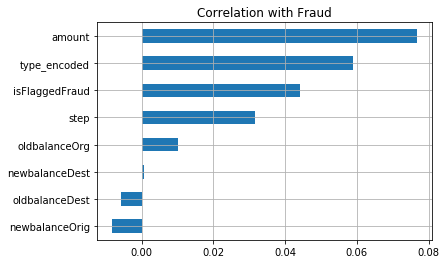

In [15]:
data[feature_list].corrwith(data[target]).sort_values().plot.barh(grid=True,title='Correlation with Fraud')

Our given feature is not highly correleted with our target variable. 

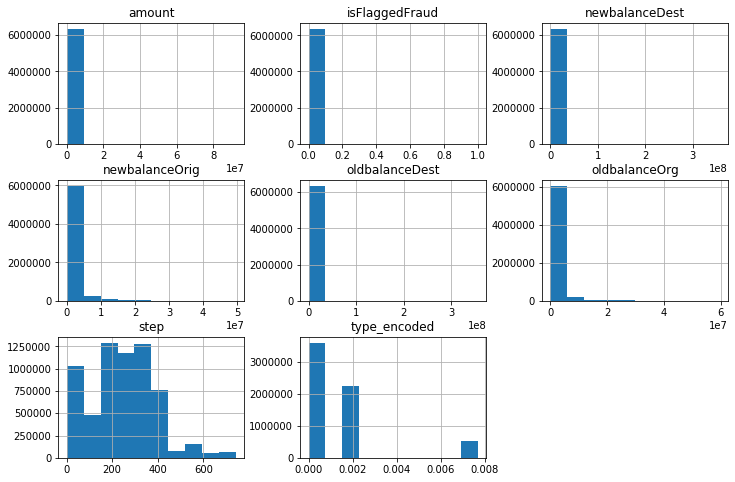

In [16]:
plt.rcParams['figure.figsize']=(12,8)
data[feature_list].hist()
plt.show()

All given feature is also highly skewed except the step.

In [17]:
data[feature_list].skew()

step                0.375177
amount             30.993949
oldbalanceOrg       5.249136
newbalanceOrig      5.176884
oldbalanceDest     19.921758
newbalanceDest     19.352302
isFlaggedFraud    630.603629
type_encoded        2.194718
dtype: float64

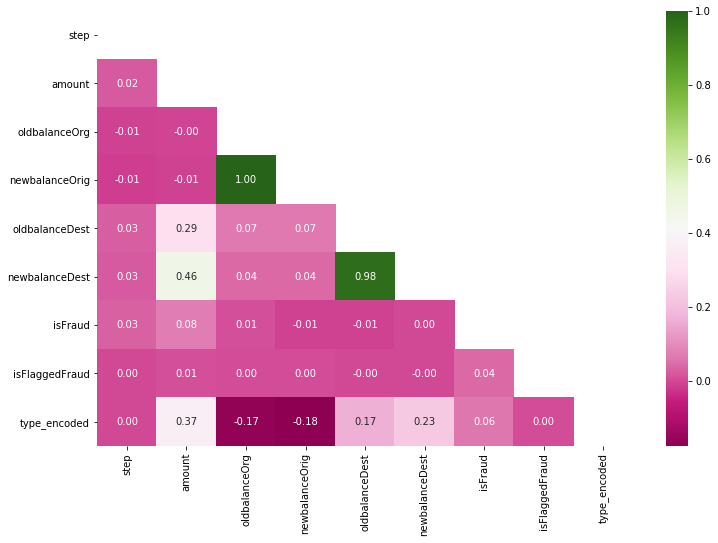

In [18]:
corr = data.corr()

sns.heatmap(corr,mask=np.triu(np.ones_like(corr)),annot=True,fmt='.2f',cmap='PiYG')

Balance debit and credit goes hand in hand so `oldBalance` and `newBalance` should be 100% correleted But old and new balance from destination is not complaint to this rule.

Possibly, there may be more fraud hapenning in this category

In [19]:
#data[['oldbalanceOrg','amount','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']]

In [20]:
data.head(10)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_encoded
0,1,9839.64,C,170136.00,160296.36,M,0.0,0.00,0,0,0.000000
1,1,1864.28,C,21249.00,19384.72,M,0.0,0.00,0,0,0.000000
2,1,181.00,C,181.00,0.00,C,0.0,0.00,1,0,0.007688
3,1,181.00,C,181.00,0.00,C,21182.0,0.00,1,0,0.001840
4,1,11668.14,C,41554.00,29885.86,M,0.0,0.00,0,0,0.000000
5,1,7817.71,C,53860.00,46042.29,M,0.0,0.00,0,0,0.000000
6,1,7107.77,C,183195.00,176087.23,M,0.0,0.00,0,0,0.000000
7,1,7861.64,C,176087.23,168225.59,M,0.0,0.00,0,0,0.000000
8,1,4024.36,C,2671.00,0.00,M,0.0,0.00,0,0,0.000000
9,1,5337.77,C,41720.00,36382.23,C,41898.0,40348.79,0,0,0.000000


In [21]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [22]:
data[data.oldbalanceOrg+data.amount != data.newbalanceOrig]['isFraud'].value_counts()

0    5360364
1       8197
Name: isFraud, dtype: int64

**Lets create a mismatch feature at Origin and Destination**

In [23]:
origin_mismatch = []
for i in data.index:
    if (min(data['oldbalanceOrg'][i],data['newbalanceOrig'][i])+data['amount'][i] == max(data['oldbalanceOrg'][i],data['newbalanceOrig'][i])):
        origin_mismatch.append(0)
    else:
        origin_mismatch.append(1)

data['origin_mismatch'] = origin_mismatch        

In [24]:
dest_mismatch = []
for i in data.index:
    if (data.nameDest[i] == 'M'):
        dest_mismatch.append(-1)
    elif (min(data['oldbalanceDest'][i],data['newbalanceDest'][i])+data['amount'][i] == max(data['oldbalanceDest'][i],data['newbalanceDest'][i])):
        dest_mismatch.append(0)
    else:
        dest_mismatch.append(1)

data['dest_mismatch'] = dest_mismatch        

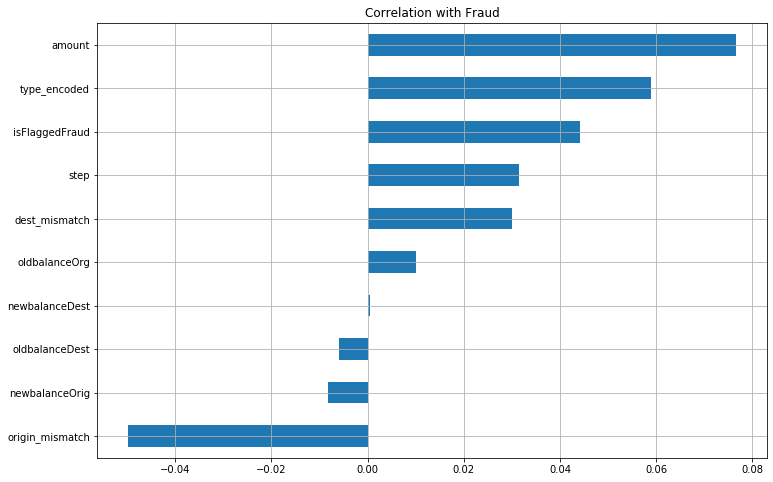

In [25]:
data.drop(target,axis=1).corrwith(data[target]).sort_values().plot.barh(grid=True,title='Correlation with Fraud')

In [26]:
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_encoded,origin_mismatch,dest_mismatch
0,1,9839.64,C,170136.0,160296.36,M,0.0,0.0,0,0,0.000000,0,-1
1,1,1864.28,C,21249.0,19384.72,M,0.0,0.0,0,0,0.000000,0,-1
2,1,181.00,C,181.0,0.00,C,0.0,0.0,1,0,0.007688,0,1
3,1,181.00,C,181.0,0.00,C,21182.0,0.0,1,0,0.001840,0,1
4,1,11668.14,C,41554.0,29885.86,M,0.0,0.0,0,0,0.000000,0,-1


In [27]:
data.drop(columns=['nameOrig','nameDest'],axis=1,inplace=True)

In [28]:
data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_encoded,origin_mismatch,dest_mismatch
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.000000,0,-1
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.000000,0,-1
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0.007688,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0.001840,0,1
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.000000,0,-1


In [29]:
feature_list = data.columns.tolist()

In [30]:
feature_list.remove(target)

In [31]:
feature_list

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFlaggedFraud',
 'type_encoded',
 'origin_mismatch',
 'dest_mismatch']

In [32]:
data.to_csv('cleanData.csv',index=False)

# 4. Algorithm Modelling

I have checked many algorithm such as (linear, non-linear,tree based, ensemble and even ANN) but Random Forest is is working best. So below is my final model

In [6]:
# Splitting data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data[feature_list], data[target],test_size = 0.2,random_state=0)

In [7]:
# importing libraries

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [8]:
classifier = RandomForestClassifier(n_jobs=-1)

In [9]:
classifier.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [10]:
ypred = classifier.predict(x_test)
confusion_matrix(y_test,ypred)

array([[1270881,       2],
       [      3,    1638]], dtype=int64)

In [11]:
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270883
           1       1.00      1.00      1.00      1641

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

